In [ ]:
!pip install numpy scipy matplotlib pandas casadi cvxpy control gurobipy
pip install casadi[complete] --upgrade


In [1]:
# Initialization of libraries
# Numerical computations and optimizations
import numpy as np
from scipy.optimize import minimize

# Plotting and visualization
import matplotlib.pyplot as plt

import os

# Data manipulation
import pandas as pd

# Symbolic computations and MPC
import casadi as ca

# FMU interaction
#from pyfmi import load_fmu


In [73]:
def optimizer_V1(T, t_s, c_el, pv, load, SOE_initial, LOH_initial): 
    # states: SOE_battery, LOH_hess
    # inputs to FMU: P_battery, P_FC_sys (start with P_FC), P_El_sys (start with P_El), state_FC, state_EL

    # V1: no auxiliaries, no thermal model, no STB state, add transitions and costs between OFF-On
    # inputs variables in MPC: P_battery, P_grid, P_FC, delta_ON_FC, delta_OFF_FC, sigma_OFF_ON_FC, P_EL, delta_ON_EL, delta_OFF_EL, sigma_OFF_ON_EL
    
    # Access global parameters
    global P_grid_max, P_battery_nom, SOE_min, SOE_max
    global LOH_min, LOH_max, C_max, eta_EL, eta_FC, P_EL_min, P_EL_max, P_EL_STB, P_FC_min, P_FC_max, P_FC_STB, r_EL, r_FC
    global alpha_EL, alpha_FC, C_EL, C_FC, c_battery
    

    N = int(T // t_s)
    
    # Initialize
    import casadi as ca
    opti = ca.Opti("conic")

    # -----------------------------
    # Variables and solver
    # -----------------------------

    SOE = opti.variable(1, N+1)  # state
    LOH = opti.variable(1, N+1)  # state
    P_batt = opti.variable(1, N)  # input
    P_batt_abs = opti.variable(1,N) # input

    P_grid_sale = opti.variable(1, N)        # input 
    P_grid_pchs = opti.variable(1, N)        # input 
    
    P_FC = opti.variable(1, N)          # input
    delta_ON_FC = opti.variable(1, N)   # binary input
    delta_OFF_FC = opti.variable(1, N)  # binary input
    sigma_OFF_ON_FC = opti.variable(1, N)  # binary input
    
    P_EL = opti.variable(1, N)          # input
    delta_ON_EL = opti.variable(1, N)   # binary input
    delta_OFF_EL = opti.variable(1, N)  # binary input
    sigma_OFF_ON_EL = opti.variable(1, N)  # binary input


    # delta_i are discrete variables (binary)
    discrete_var = [0]*(N+1) + [0]*(N+1) + [0]*N + [0]*N + [0]*N + [0]*N + [0]*N + [1]*N + [1]*N + [1]*N + [0]*N + [1]*N + [1]*N + [1]*N

    # Solver
    opti.solver('gurobi', {'discrete': discrete_var})
    #opti.solver('bonmin', {'discrete': discrete_var, 'bonmin.tol': 1e-4, 'bonmin.print_level': 0, 'print_time': 0})


    # -----------------------------
    # Constraints
    # -----------------------------

    
    # Initial storage level
    opti.subject_to(SOE[0] == SOE_initial)
    opti.subject_to(LOH[0] == LOH_initial)

    # Impose initial state of FC and electrolyzer to be OFF
    opti.subject_to(delta_OFF_EL[0] == 1)
    opti.subject_to(delta_OFF_FC[0] == 1)
    

    # Constraints at every time step
    for t in range(N):

            # Bounds on grid
            opti.subject_to(pv[t] + P_grid_pchs[t] + P_FC[t] == load[t] + P_grid_sale[t] + P_batt[t] + P_EL[t])
            opti.subject_to(P_grid_sale[t]>=0)
            opti.subject_to(P_grid_sale[t]<=P_grid_max)
            opti.subject_to(P_grid_pchs[t]>=0)
            opti.subject_to(P_grid_pchs[t]<=P_grid_max)

            # Bounds on battery and SOE
            opti.subject_to(P_batt_abs[t] >= P_batt[t])
            opti.subject_to(P_batt_abs[t] >= -P_batt[t])
        
            
            opti.subject_to(P_batt[t]>= -0.85 * P_battery_nom)
            opti.subject_to(P_batt[t]<= 0.85 * P_battery_nom)
        
            opti.subject_to(SOE[t+1] == SOE[t] + P_batt[t] * t_s/3600)
            opti.subject_to(SOE[t] >= SOE_min)
            opti.subject_to(SOE[t] <= SOE_max)
            
            # Bounds on hydrogen storage 
            opti.subject_to(LOH[t+1] == LOH[t] + (P_EL[t] * eta_EL - P_FC[t]/eta_FC) * t_s / C_max)
            opti.subject_to(LOH[t] >= LOH_min)
            opti.subject_to(LOH[t] <= LOH_max)                

            # Constraints on electrolyzer
            # Bounds when ON                
            opti.subject_to(P_EL[t] >= delta_ON_EL[t] * P_EL_min)
            opti.subject_to(P_EL[t] <= delta_ON_EL[t] * P_EL_max)
        
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_EL[t+1] - P_EL[t] <= r_EL)
                opti.subject_to(P_EL[t] - P_EL[t+1] <= r_EL)
                            
            # Constraints on fuel cell
            # Bounds when ON
            opti.subject_to(P_FC[t] >= delta_ON_FC[t] * P_FC_min)
            opti.subject_to(P_FC[t] <= delta_ON_FC[t] * P_FC_max)
            
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_FC[t+1] - P_FC[t] <= r_FC)
                opti.subject_to(P_FC[t] - P_FC[t+1] <= r_FC)
                            
            # States 
            opti.subject_to(delta_ON_EL[t] >= 0)
            opti.subject_to(delta_ON_EL[t] <= 1)
            opti.subject_to(delta_OFF_EL[t] >= 0)
            opti.subject_to(delta_OFF_EL[t] <= 1)
            opti.subject_to(sigma_OFF_ON_EL[t] >= 0)
            opti.subject_to(sigma_OFF_ON_EL[t] <= 1)

            opti.subject_to(delta_ON_FC[t] >= 0)
            opti.subject_to(delta_ON_FC[t] <= 1)
            opti.subject_to(delta_OFF_FC[t] >= 0)
            opti.subject_to(delta_OFF_FC[t] <= 1)
            opti.subject_to(sigma_OFF_ON_FC[t] >= 0)
            opti.subject_to(sigma_OFF_ON_FC[t] <= 1)    
                           
            opti.subject_to(delta_ON_EL[t] + delta_OFF_EL[t] == 1)
            opti.subject_to(delta_ON_FC[t] + delta_OFF_FC[t] == 1)
            
            # Transitions EL and FC
            if t >= 1 and t <= N:              
                opti.subject_to(sigma_OFF_ON_EL[t] - delta_OFF_EL[t-1] <= 0)
                opti.subject_to(sigma_OFF_ON_EL[t] - delta_ON_EL[t] <= 0)
                opti.subject_to(delta_OFF_EL[t-1] + delta_ON_EL[t] - sigma_OFF_ON_EL[t] <= 1)

                opti.subject_to(sigma_OFF_ON_FC[t] - delta_OFF_FC[t-1] <= 0)
                opti.subject_to(sigma_OFF_ON_FC[t] - delta_ON_FC[t] <= 0)
                opti.subject_to(delta_OFF_FC[t-1] + delta_ON_FC[t] - sigma_OFF_ON_FC[t] <= 1)


            # Transitions dwwelling time for OFF-STB
            T_CLD_EL = 2 
            T_CLD_FC = 2
             # Electrolyzer constraints
            if t >= 1 and t < N - T_CLD_EL:
                opti.subject_to(sigma_OFF_ON_EL[t] - sigma_OFF_ON_EL[t-1] <= sigma_OFF_ON_EL[t+1:t + T_CLD_EL+1])
                sigma_sum_EL = sum([sigma_OFF_ON_EL[t-j] for j in range(T_CLD_EL)])
                opti.subject_to(sigma_sum_EL <= T_CLD_EL)
    
            # Fuel Cell constraints
            if t >= 1 and t < N - T_CLD_FC:
                opti.subject_to(sigma_OFF_ON_FC[t] - sigma_OFF_ON_FC[t-1] <= sigma_OFF_ON_FC[t+1:t + T_CLD_FC+1])
                sigma_sum_FC = sum([sigma_OFF_ON_FC[t-j] for j in range(T_CLD_FC)])
                opti.subject_to(sigma_sum_FC <= T_CLD_FC)
             
                    
            # Bilinear to linear


    # -----------------------------
    # Objective
    # -----------------------------

    obj = sum(alpha_EL * t_s/3600 * delta_ON_EL[t] + C_EL * sigma_OFF_ON_EL[t] + alpha_FC * t_s/3600 * delta_ON_FC[t] 
    + C_FC * sigma_OFF_ON_FC[t] + c_battery * P_batt_abs[t] + 1000*(c_el[t]/1000 * P_grid_pchs[t] - 0 * c_el[t]/1000 * P_grid_sale[t]) * t_s/3600 for t in range(N))
    opti.minimize(obj)
    
    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()
    
    SOE_opt = sol.value(SOE)
    LOH_opt = sol.value(LOH)
    P_batt_opt = sol.value(P_batt)
    P_batt_abs = sol.value(P_batt_abs)

    P_grid_sale_opt = sol.value(P_grid_sale)
    P_grid_pchs_opt = sol.value(P_grid_pchs)
    
    P_FC_opt = sol.value(P_FC)  
    delta_ON_FC_opt = sol.value(delta_ON_FC)
    delta_OFF_FC_opt = sol.value(delta_OFF_FC)
    sigma_OFF_ON_FC_opt = sol.value(sigma_OFF_ON_FC)
    P_EL_opt = sol.value(P_EL)
    delta_ON_EL_opt = sol.value(delta_ON_EL)
    delta_OFF_EL_opt = sol.value(delta_OFF_EL)
    sigma_OFF_ON_EL_opt = sol.value(sigma_OFF_ON_EL)

    obj_opt = round(sol.value(obj), 2)

    return SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_OFF_EL_opt, sigma_OFF_ON_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_OFF_FC_opt, sigma_OFF_ON_FC_opt, P_FC_opt, obj_opt
        

In [83]:
def optimizer_V2(T, t_s, c_el, pv, load, SOE_initial, LOH_initial): 
    # Adapt inputs: T (horizon of simulation), ts (sampling time), SOE_battery, LOH_hess, pv, load, c_el (electricity prices)
    # states: SOE_battery, LOH_hess
    # inputs to FMU: P_battery, P_FC_sys (start with P_FC), P_El_sys (start with P_El), state_FC, state_EL

    # V2: no auxiliaries, no thermal model, include STB state, and transitions and costs between OFF-On
    # inputs variables in MPC: P_battery, P_grid, P_FC, delta_ON_FC, delta_OFF_FC, sigma_OFF_ON_FC, P_EL, delta_ON_EL, delta_OFF_EL, sigma_OFF_ON_EL
    
    # Access global parameters
    global P_grid_max, P_battery_nom, SOE_min, SOE_max
    global LOH_min, LOH_max, C_max, eta_EL, eta_FC, P_EL_min, P_EL_max, P_EL_STB, P_FC_min, P_FC_max, P_FC_STB, r_EL, r_FC
    global alpha_EL, alpha_FC, C_EL_ON, C_EL_STB, C_EL_OFF, C_FC_ON, C_FC_STB, C_FC_OFF, c_battery

    N = int(T // t_s)
    
    # Initialize
    import casadi as ca
    opti = ca.Opti("conic")

    # -----------------------------
    # Variables and solver
    # -----------------------------

 
    SOE = opti.variable(1, N+1)  # state
    LOH = opti.variable(1, N+1)  # state

    P_batt = opti.variable(1, N)  # input
    P_batt_abs = opti.variable(1,N) # binary input

    P_grid_sale = opti.variable(1, N)        # input 
    P_grid_pchs = opti.variable(1, N)        # input 

    P_FC = opti.variable(1, N)          # input
    delta_ON_FC = opti.variable(1, N)   # binary input
    delta_STB_FC = opti.variable(1, N)  # binary input
    delta_OFF_FC = opti.variable(1, N)  # binary input
    sigma_OFF_STB_FC = opti.variable(1, N)  # binary input
    sigma_STB_OFF_FC = opti.variable(1, N)  # binary input
    sigma_OFF_ON_FC = opti.variable(1, N)  # binary input
    sigma_ON_OFF_FC = opti.variable(1, N)  # binary input
    sigma_STB_ON_FC = opti.variable(1, N)  # binary input
    sigma_ON_STB_FC = opti.variable(1, N)  # binary input

    P_EL = opti.variable(1, N)          # input
    delta_ON_EL = opti.variable(1, N)   # binary input
    delta_STB_EL = opti.variable(1, N)  # binary input
    delta_OFF_EL = opti.variable(1, N)  # binary input
    sigma_OFF_STB_EL = opti.variable(1, N)  # binary input
    sigma_STB_OFF_EL = opti.variable(1, N)  # binary input
    sigma_OFF_ON_EL = opti.variable(1, N)  # binary input
    sigma_ON_OFF_EL = opti.variable(1, N)  # binary input
    sigma_STB_ON_EL = opti.variable(1, N)  # binary input
    sigma_ON_STB_EL = opti.variable(1, N)  # binary input

    # binary inputs are discrete variables 
    discrete_var = [0]*(N+1) + [0]*(N+1) + [0]*N + [0]*N + [0]*N + [0]*N + [0]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [0]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N 

    # Solver
    opti.solver('gurobi', {'discrete': discrete_var})
    #opti.solver('bonmin', {'discrete': discrete_var, 'bonmin.tol': 1e-4, 'bonmin.print_level': 0, 'print_time': 0})

    # -----------------------------
    # Constraints
    # -----------------------------
    
    # Initial storage level
    opti.subject_to(SOE[0] == SOE_initial)
    opti.subject_to(LOH[0] == LOH_initial)

    # Impose initial state of FC and electrolyzer to be OFF
    opti.subject_to(delta_OFF_EL[0] == 1)
    opti.subject_to(delta_OFF_FC[0] == 1)

    # Constraints at every time step
    for t in range(N):
        # Bounds on grid
        opti.subject_to(pv[t] + P_grid_pchs[t] + (0.89*P_FC[t] - P_FC_STB * delta_STB_FC[t]) 
                        == load[t] + P_grid_sale[t] + P_batt[t]  + (1.19*P_EL[t] + P_EL_STB * delta_STB_EL[t]))
        opti.subject_to(P_grid_sale[t]>=0)
        opti.subject_to(P_grid_sale[t]<=P_grid_max)
        opti.subject_to(P_grid_pchs[t]>=0)
        opti.subject_to(P_grid_pchs[t]<=P_grid_max)

        # Bounds on battery and SOE
        opti.subject_to(P_batt_abs[t] >= P_batt[t])
        opti.subject_to(P_batt_abs[t] >= -P_batt[t])
        
        opti.subject_to(P_batt[t]>= - 0.9 * P_battery_nom)
        opti.subject_to(P_batt[t]<= 0.9 * P_battery_nom)
    
        opti.subject_to(SOE[t+1] == SOE[t] + P_batt[t] * t_s/3600)
        opti.subject_to(SOE[t] >= SOE_min)
        opti.subject_to(SOE[t] <= SOE_max)
        
        # Bounds on hydrogen storage 
        opti.subject_to(LOH[t+1] == LOH[t] + (P_EL[t] * eta_EL - P_FC[t]/eta_FC) * t_s /C_max)
        opti.subject_to(LOH[t] >= LOH_min)
        opti.subject_to(LOH[t] <= LOH_max)                

        # Constraints on electrolyzer
        # Bounds when ON                
        opti.subject_to(P_EL[t] >= delta_ON_EL[t] * P_EL_min)
        opti.subject_to(P_EL[t] <= delta_ON_EL[t] * P_EL_max)
    
        # Ramping constraints                
        if t < N-1:                
            opti.subject_to(P_EL[t+1] - P_EL[t] <= r_EL)
            opti.subject_to(P_EL[t] - P_EL[t+1] <= r_EL)
                        
        # Constraints on fuel cell
        # Bounds when ON
        opti.subject_to(P_FC[t] >= delta_ON_FC[t] * P_FC_min)
        opti.subject_to(P_FC[t] <= delta_ON_FC[t] * P_FC_max)
        
        # Ramping constraints                
        if t < N-1:                
            opti.subject_to(P_FC[t+1] - P_FC[t] <= r_FC)
            opti.subject_to(P_FC[t] - P_FC[t+1] <= r_FC)
                        
        # States    
        opti.subject_to(delta_ON_EL[t] >= 0)
        opti.subject_to(delta_ON_EL[t] <= 1)
        opti.subject_to(delta_OFF_EL[t] >= 0)
        opti.subject_to(delta_OFF_EL[t] <= 1)
        opti.subject_to(delta_STB_EL[t] >= 0)
        opti.subject_to(delta_STB_EL[t] <= 1)

        opti.subject_to(delta_ON_FC[t] >= 0)
        opti.subject_to(delta_ON_FC[t] <= 1)
        opti.subject_to(delta_OFF_FC[t] >= 0)
        opti.subject_to(delta_OFF_FC[t] <= 1)
        opti.subject_to(delta_STB_FC[t] >= 0)
        opti.subject_to(delta_STB_FC[t] <= 1)

        opti.subject_to(delta_ON_EL[t] + delta_STB_EL[t] + delta_OFF_EL[t] == 1)
        opti.subject_to(delta_ON_FC[t] + delta_STB_FC[t] + delta_OFF_FC[t] == 1)
        
        # Transitions EL
        opti.subject_to(sigma_OFF_STB_EL[t] >= 0)
        opti.subject_to(sigma_OFF_STB_EL[t] <= 1)  
        opti.subject_to(sigma_STB_OFF_EL[t] >= 0)
        opti.subject_to(sigma_STB_ON_EL[t] >= 0)
        opti.subject_to(sigma_ON_STB_EL[t] >= 0)
        opti.subject_to(sigma_ON_OFF_EL[t] >= 0)
        opti.subject_to(sigma_OFF_ON_EL[t] == 0)

        # OFF to STB
        opti.subject_to(sigma_OFF_STB_EL[t] - delta_OFF_EL[t-1] <= 0)
        opti.subject_to(sigma_OFF_STB_EL[t] - delta_STB_EL[t] <= 0)
        opti.subject_to(delta_OFF_EL[t-1] + delta_STB_EL[t] - sigma_OFF_STB_EL[t] <= 1)
        # STB to OFF
        opti.subject_to(sigma_STB_OFF_EL[t] - delta_STB_EL[t-1] <= 0)
        opti.subject_to(sigma_STB_OFF_EL[t] - delta_OFF_EL[t] <= 0)
        opti.subject_to(delta_STB_EL[t-1] + delta_OFF_EL[t] - sigma_STB_OFF_EL[t] <= 1)
        # STB to ON
        opti.subject_to(sigma_STB_ON_EL[t] - delta_STB_EL[t-1] <= 0)
        opti.subject_to(sigma_STB_ON_EL[t] - delta_ON_EL[t] <= 0)
        opti.subject_to(delta_STB_EL[t-1] + delta_ON_EL[t] - sigma_STB_ON_EL[t] <= 1)
        # ON to STB
        opti.subject_to(sigma_ON_STB_EL[t] - delta_ON_EL[t-1] <= 0)
        opti.subject_to(sigma_ON_STB_EL[t] - delta_STB_EL[t] <= 0)
        opti.subject_to(delta_ON_EL[t-1] + delta_STB_EL[t] - sigma_ON_STB_EL[t] <= 1)
        # ON to OFF
        opti.subject_to(sigma_ON_OFF_EL[t] - delta_ON_EL[t-1] <= 0)
        opti.subject_to(sigma_ON_OFF_EL[t] - delta_OFF_EL[t] <= 0)
        opti.subject_to(delta_ON_EL[t-1] + delta_OFF_EL[t] - sigma_ON_OFF_EL[t] <= 1)
        # OFF to ON
        opti.subject_to(sigma_OFF_ON_EL[t] == 0)               
        opti.subject_to(sigma_OFF_ON_EL[t] - delta_OFF_EL[t-1] <= 0)
        opti.subject_to(sigma_OFF_ON_EL[t] - delta_ON_EL[t] <= 0)
        opti.subject_to(delta_OFF_EL[t-1] + delta_ON_EL[t] - sigma_OFF_ON_EL[t] <= 1)


        # Transitions FC 
        opti.subject_to(sigma_OFF_STB_FC[t] >= 0)
        opti.subject_to(sigma_OFF_STB_FC[t] <= 1)
        opti.subject_to(sigma_STB_OFF_FC[t] >= 0)
        opti.subject_to(sigma_STB_ON_FC[t] >= 0)
        opti.subject_to(sigma_ON_STB_FC[t] >= 0)
        opti.subject_to(sigma_ON_OFF_FC[t] >= 0)
        opti.subject_to(sigma_OFF_ON_FC[t] == 0)

        # OFF to STB
        opti.subject_to(sigma_OFF_STB_FC[t] - delta_OFF_FC[t-1] <= 0)
        opti.subject_to(sigma_OFF_STB_FC[t] - delta_STB_FC[t] <= 0)
        opti.subject_to(delta_OFF_FC[t-1] + delta_STB_FC[t] - sigma_OFF_STB_FC[t] <= 1)
        # STB to OFF
        opti.subject_to(sigma_STB_OFF_FC[t] - delta_STB_FC[t-1] <= 0)
        opti.subject_to(sigma_STB_OFF_FC[t] - delta_OFF_FC[t] <= 0)
        opti.subject_to(delta_STB_FC[t-1] + delta_OFF_FC[t] - sigma_STB_OFF_FC[t] <= 1)
        # STB to ON
        opti.subject_to(sigma_STB_ON_FC[t] - delta_STB_FC[t-1] <= 0)
        opti.subject_to(sigma_STB_ON_FC[t] - delta_ON_FC[t] <= 0)
        opti.subject_to(delta_STB_FC[t-1] + delta_ON_FC[t] - sigma_STB_ON_FC[t] <= 1)
        # ON to STB
        opti.subject_to(sigma_ON_STB_FC[t] - delta_ON_FC[t-1] <= 0)
        opti.subject_to(sigma_ON_STB_FC[t] - delta_STB_FC[t] <= 0)
        opti.subject_to(delta_ON_FC[t-1] + delta_STB_FC[t] - sigma_ON_STB_FC[t] <= 1)
        # ON to OFF
        opti.subject_to(sigma_ON_OFF_FC[t] - delta_ON_FC[t-1] <= 0)
        opti.subject_to(sigma_ON_OFF_FC[t] - delta_OFF_FC[t] <= 0)
        opti.subject_to(delta_ON_FC[t-1] + delta_OFF_FC[t] - sigma_ON_OFF_FC[t] <= 1)
        # OFF to ON              
        opti.subject_to(sigma_OFF_ON_FC[t] == 0) 
        opti.subject_to(sigma_OFF_ON_FC[t] - delta_OFF_FC[t-1] <= 0)
        opti.subject_to(sigma_OFF_ON_FC[t] - delta_ON_FC[t] <= 0)
        opti.subject_to(delta_OFF_FC[t-1] + delta_ON_FC[t] - sigma_OFF_ON_FC[t] <= 1)

        # Transitions dwwelling time for OFF-STB
        T_CLD_EL = 1
        T_CLD_FC = 1
        # Electrolyzer constraints
        if t >= 1 and t < N - T_CLD_EL:
            opti.subject_to(sigma_OFF_STB_EL[t] - sigma_OFF_STB_EL[t-1] <= sigma_OFF_STB_EL[t+1:t + T_CLD_EL+1])
            sigma_sum_EL = sum([sigma_OFF_STB_EL[t-j] for j in range(T_CLD_EL)]) # should go to rage(T_CDL_EL+1)
            opti.subject_to(sigma_sum_EL <= T_CLD_EL)
        
        # Fuel Cell constraints
        if t >= 1 and t < N - T_CLD_FC:
            opti.subject_to(sigma_OFF_STB_FC[t] - sigma_OFF_STB_FC[t-1] <= sigma_OFF_STB_FC[t+1:t + T_CLD_FC+1])
            sigma_sum_FC = sum([sigma_OFF_STB_FC[t-j] for j in range(T_CLD_FC)])  # should go to rage(T_CDL_FC+1)
            opti.subject_to(sigma_sum_FC <= T_CLD_FC)
             
                    


    # -----------------------------
    # Objective
    # -----------------------------

    obj = sum(alpha_EL * t_s/3600 * delta_ON_EL[t] + C_EL_ON * sigma_OFF_STB_EL[t] + C_EL_STB * sigma_STB_OFF_EL[t] + C_EL_OFF * sigma_ON_OFF_EL[t] 
    + alpha_FC * t_s/3600 * delta_ON_FC[t] + C_FC_ON * sigma_OFF_STB_FC[t] + C_FC_STB * sigma_STB_OFF_FC[t] + C_FC_OFF * sigma_ON_OFF_FC[t] 
    + c_battery * P_batt_abs[t] + 1000 * (c_el[t]/1000 * P_grid_pchs[t] - 0 * c_el[t]/1000 * P_grid_sale[t]) * t_s/3600 for t in range(N))
    opti.minimize(obj)
    
    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()
    
    SOE_opt = sol.value(SOE)
    LOH_opt = sol.value(LOH)

    P_batt_opt = sol.value(P_batt)
    P_batt_abs = sol.value(P_batt_abs)

    P_grid_sale_opt = sol.value(P_grid_sale)
    P_grid_pchs_opt = sol.value(P_grid_pchs)

    P_FC_opt = sol.value(P_FC)  
    delta_ON_FC_opt = sol.value(delta_ON_FC)
    delta_STB_FC_opt = sol.value(delta_STB_FC)
    delta_OFF_FC_opt = sol.value(delta_OFF_FC)
    sigma_OFF_STB_FC_opt = sol.value(sigma_OFF_STB_FC)
    sigma_STB_OFF_FC_opt = sol.value(sigma_STB_OFF_FC)
    sigma_ON_STB_FC_opt = sol.value(sigma_ON_STB_FC)
    sigma_STB_ON_FC_opt = sol.value(sigma_STB_ON_FC)
    sigma_ON_OFF_FC_opt = sol.value(sigma_ON_OFF_FC)
    sigma_OFF_ON_FC_opt = sol.value(sigma_OFF_ON_FC)

    P_EL_opt = sol.value(P_EL)  
    delta_ON_EL_opt = sol.value(delta_ON_EL)
    delta_STB_EL_opt = sol.value(delta_STB_EL)
    delta_OFF_EL_opt = sol.value(delta_OFF_EL)
    sigma_OFF_STB_EL_opt = sol.value(sigma_OFF_STB_EL)
    sigma_STB_OFF_EL_opt = sol.value(sigma_STB_OFF_EL)
    sigma_ON_STB_EL_opt = sol.value(sigma_ON_STB_EL)
    sigma_STB_ON_EL_opt = sol.value(sigma_STB_ON_EL)
    sigma_ON_OFF_EL_opt = sol.value(sigma_ON_OFF_EL)
    sigma_OFF_ON_EL_opt = sol.value(sigma_OFF_ON_EL)


    obj_opt = round(sol.value(obj), 3)

    return SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_STB_EL_opt, delta_OFF_EL_opt, sigma_OFF_STB_EL_opt, sigma_STB_OFF_EL_opt, sigma_ON_STB_EL_opt, sigma_STB_ON_EL_opt, sigma_ON_OFF_EL_opt, sigma_OFF_ON_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_STB_FC_opt, delta_OFF_FC_opt, sigma_OFF_STB_FC_opt, sigma_STB_OFF_FC_opt, sigma_ON_STB_FC_opt, sigma_STB_ON_FC_opt, sigma_ON_OFF_FC_opt, sigma_OFF_ON_FC_opt , P_FC_opt, obj_opt
        


In [84]:
def optimizer_V3(T, t_s, c_el, pv, load, SOE_initial, LOH_initial): 
    # states: SOE_battery, LOH_hess
    # inputs to FMU: P_battery, P_FC_sys (start with P_FC), P_El_sys (start with P_El), state_FC, state_EL

    # V3: no auxiliaries, no thermal model, no STB state, add transitions and costs between OFF-On, PWA efficiency
    # inputs variables in MPC: P_battery, P_grid, P_FC, delta_ON_FC, delta_OFF_FC, sigma_OFF_ON_FC, P_EL, delta_ON_EL, delta_OFF_EL, sigma_OFF_ON_EL
    
    # Access global parameters
    global m, M, P_grid_max, P_battery_nom, SOE_min, SOE_max
    global LOH_min, LOH_max, C_max, eta_EL, eta_FC, P_EL_min, P_EL_max, P_EL_STB, P_FC_min, P_FC_max, P_FC_STB, r_EL, r_FC
    global alpha_EL, alpha_FC, C_EL, C_FC, c_battery
    
 

    N = int(T // t_s)
    
    # Initialize
    import casadi as ca
    #opti = ca.Opti()
    opti = ca.Opti("conic")


    # -----------------------------
    # Variables and solver
    # -----------------------------

    SOE = opti.variable(1, N+1)  # state
    LOH = opti.variable(1, N+1)  # state

    P_batt = opti.variable(1, N)  # input
    P_batt_abs = opti.variable(1,N) # input

    P_grid_sale = opti.variable(1, N)        # input 
    P_grid_pchs = opti.variable(1, N)        # input 

    P_FC = opti.variable(1, N)          # input
    delta_ON_FC = opti.variable(1, N)   # binary input
    delta_OFF_FC = opti.variable(1, N)  # binary input
    sigma_OFF_ON_FC = opti.variable(1, N)  # binary input
    x1_FC = opti.variable(1, N)   # PWA binary input
    x2_FC = opti.variable(1, N)  # PWA binary input
    x3_FC = opti.variable(1, N)  # PWA binary input
    z1_FC = opti.variable(1, N)          # bilinear input
    z2_FC = opti.variable(1, N)          # bilinear input
    z3_FC = opti.variable(1, N)          # bilinear input

    P_EL = opti.variable(1, N)          # input
    delta_ON_EL = opti.variable(1, N)   # binary input
    delta_OFF_EL = opti.variable(1, N)  # binary input
    sigma_OFF_ON_EL = opti.variable(1, N)  # binary input
    x1_EL = opti.variable(1, N)   # PWA binary input
    x2_EL = opti.variable(1, N)  # PWA binary input
    x3_EL = opti.variable(1, N)  # PWA binary input
    z1_EL = opti.variable(1, N)          # bilinear input
    z2_EL = opti.variable(1, N)          # bilinear input
    z3_EL = opti.variable(1, N)          # bilinear input

    # binary inputs are discrete variables 
    discrete_var = [0]*(N+1) + [0]*(N+1) + [0]*N + [0]*N + [0]*N + [0]*N + [0]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [0]*N + [0]*N + [0]*N + [0]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [0]*N + [0]*N + [0]*N

    # Solver
    opti.solver('gurobi', {'discrete': discrete_var})
    #opti.solver('bonmin', {'discrete': discrete_var, 'bonmin.tol': 1e-4, 'bonmin.print_level': 0, 'print_time': 0})

    # -----------------------------
    # Constraints
    # -----------------------------

    
    # Initial storage level
    opti.subject_to(SOE[0] == SOE_initial)
    opti.subject_to(LOH[0] == LOH_initial)

    # Impose initial state of FC and electrolyzer to be OFF
    opti.subject_to(delta_OFF_EL[0] == 1)
    opti.subject_to(delta_OFF_FC[0] == 1)


    

    # Constraints at every time step
    for t in range(N):

            # Bounds on grid
            opti.subject_to(pv[t] + P_grid_pchs[t] + 0.89*P_FC[t] == load[t] + P_grid_sale[t] + P_batt[t] + 1.19*P_EL[t])
            opti.subject_to(P_grid_sale[t]>=0)
            opti.subject_to(P_grid_sale[t]<=P_grid_max)
            opti.subject_to(P_grid_pchs[t]>=0)
            opti.subject_to(P_grid_pchs[t]<=P_grid_max)

            # Bounds on battery and SOE
            opti.subject_to(P_batt_abs[t] >= P_batt[t])
            opti.subject_to(P_batt_abs[t] >= -P_batt[t])
            
            opti.subject_to(P_batt[t]>= -0.9 * P_battery_nom)
            opti.subject_to(P_batt[t]<= 0.9 * P_battery_nom)
        
            opti.subject_to(SOE[t+1] == SOE[t] + P_batt[t]  * t_s/3600)
            opti.subject_to(SOE[t] >= SOE_min)
            opti.subject_to(SOE[t] <= SOE_max)
            
            #PWA efficiency electrolyzer
            # We introduce 3 binary variables xi to activate the piece i of the PWA
            opti.subject_to(x1_EL[t] >= 0)
            opti.subject_to(x1_EL[t] <= 1)
            opti.subject_to(x2_EL[t] >= 0)
            opti.subject_to(x2_EL[t] <= 1)
            opti.subject_to(x3_EL[t] >= 0)
            opti.subject_to(x3_EL[t] <= 1)    

            opti.subject_to(delta_OFF_EL[t] + x1_EL[t] + x2_EL[t] + x3_EL[t] == 1)

            opti.subject_to(P_EL[t] >= P_EL_min - M * (1-x1_EL[t]))
            opti.subject_to(P_EL[t] <= 1700 + M * (1-x1_EL[t]))
            opti.subject_to(P_EL[t] >= 1700 - M * (1-x2_EL[t]))
            opti.subject_to(P_EL[t] <= 3750 + M * (1-x2_EL[t]))
            opti.subject_to(P_EL[t] >= 3750 - M * (1-x3_EL[t]))
            opti.subject_to(P_EL[t] <= P_EL_max + M * (1-x3_EL[t]))
           
            # Piecewise linear expression to replace P_EL * eta_EL:
            #Non-linear: P_eta_EL = x1_EL[t] * (0.71685 * P_EL[t] + 71.8325) + x2_EL[t] * (0.56641 * P_EL[t] + 327.2039) + x3_EL[t] * (0.48142 * P_EL[t] + 616.6985)
            # We introduce 3 variables zi to replace the bilinear product xi * P_EL
            P_eta_EL =  0.68186 * z1_EL[t] + x1_EL[t] * 41.1124 + 0.59523 * z2_EL[t] + x2_EL[t] * 192.3783 + 0.53432 * z3_EL[t] + x3_EL[t] * 400.5637
            
            # Bi-linear constraints
            # For z1_EL and x1_EL
            opti.subject_to(z1_EL[t] >= m * x1_EL[t])
            opti.subject_to(z1_EL[t] <= M * x1_EL[t])
            opti.subject_to(z1_EL[t] >= P_EL[t] - M * (1 - x1_EL[t]))
            opti.subject_to(z1_EL[t] <= P_EL[t] + m * (1 - x1_EL[t]))
            # For z2_EL and x2_EL
            opti.subject_to(z2_EL[t] >= m * x2_EL[t])
            opti.subject_to(z2_EL[t] <= M * x2_EL[t])
            opti.subject_to(z2_EL[t] >= P_EL[t] - M * (1 - x2_EL[t]))
            opti.subject_to(z2_EL[t] <= P_EL[t] + m * (1 - x2_EL[t]))
            # For z3_EL and x3_EL
            opti.subject_to(z3_EL[t] >= m * x3_EL[t])
            opti.subject_to(z3_EL[t] <= M * x3_EL[t])
            opti.subject_to(z3_EL[t] >= P_EL[t] - M * (1 - x3_EL[t]))
            opti.subject_to(z3_EL[t] <= P_EL[t] + m * (1 - x3_EL[t]))

            #PWA efficiency fuel cell
            # We introduce 3 binary variables xi to activate the piece i of the PWA
            opti.subject_to(x1_FC[t] >= 0)
            opti.subject_to(x1_FC[t] <= 1)
            opti.subject_to(x2_FC[t] >= 0)
            opti.subject_to(x2_FC[t] <= 1)
            opti.subject_to(x3_FC[t] >= 0)
            opti.subject_to(x3_FC[t] <= 1)    

            opti.subject_to(delta_OFF_FC[t] + x1_FC[t] + x2_FC[t] + x3_FC[t] == 1)

            opti.subject_to(P_FC[t] >= P_FC_min - M * (1-x1_FC[t]))
            opti.subject_to(P_FC[t] <= 2200 + M * (1-x1_FC[t]))
            opti.subject_to(P_FC[t] >= 2200 - M * (1-x2_FC[t]))
            opti.subject_to(P_FC[t] <= 3800 + M * (1-x2_FC[t]))
            opti.subject_to(P_FC[t] >= 3800 - M * (1-x3_FC[t]))
            opti.subject_to(P_FC[t] <= P_FC_max + M * (1-x3_FC[t]))

            # Piecewise linear expression to replace P_FC / eta_FC:
            #Non-linear: P_eta_FC = x1_FC[t] * (2.8347 * P_FC[t] - 292.4739) + x2_FC[t] * (4.0384 * P_FC[t] -2929.9436) + x3_FC[t] * (6.3259 * P_FC[t] + 11682.9301)
            # We introduce 3 variables zi to replace the bilinear product xi * P_FC
            P_eta_FC = 2.8474 * z1_FC[t] - x1_FC[t] * 322.7086 +  3.7637 * z2_FC[t] - x2_FC[t] * 2337.5082 + 4.9519 * z3_FC[t] - x3_FC[t] * 6862.2995

            # Bi-linear constraints
            # For z1_FC and x1_FC
            opti.subject_to(z1_FC[t] >= m * x1_FC[t])
            opti.subject_to(z1_FC[t] <= M * x1_FC[t])
            opti.subject_to(z1_FC[t] >= P_FC[t] - M * (1 - x1_FC[t]))
            opti.subject_to(z1_FC[t] <= P_FC[t] + m * (1 - x1_FC[t]))
            # For z2_FC and x2_FC
            opti.subject_to(z2_FC[t] >= m * x2_FC[t])
            opti.subject_to(z2_FC[t] <= M * x2_FC[t])
            opti.subject_to(z2_FC[t] >= P_FC[t] - M * (1 - x2_FC[t]))
            opti.subject_to(z2_FC[t] <= P_FC[t] + m * (1 - x2_FC[t]))
            # For z3_FC and x3_FC
            opti.subject_to(z3_FC[t] >= m * x3_FC[t])
            opti.subject_to(z3_FC[t] <= M * x3_FC[t])
            opti.subject_to(z3_FC[t] >= P_FC[t] - M * (1 - x3_FC[t]))
            opti.subject_to(z3_FC[t] <= P_FC[t] + m * (1 - x3_FC[t]))


            # Bounds on hydrogen storage 
            opti.subject_to(LOH[t+1] == LOH[t] + (P_eta_EL - P_eta_FC)/ C_max * t_s )
            opti.subject_to(LOH[t] >= LOH_min)
            opti.subject_to(LOH[t] <= LOH_max)                

            # Constraints on electrolyzer
            # Bounds when ON                
            opti.subject_to(P_EL[t] >= delta_ON_EL[t] * P_EL_min)
            opti.subject_to(P_EL[t] <= delta_ON_EL[t] * P_EL_max)
        
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_EL[t+1] - P_EL[t] <= r_EL)
                opti.subject_to(P_EL[t] - P_EL[t+1] <= r_EL)
                            
            # Constraints on fuel cell
            # Bounds when ON
            opti.subject_to(P_FC[t] >= delta_ON_FC[t] * P_FC_min)
            opti.subject_to(P_FC[t] <= delta_ON_FC[t] * P_FC_max)
            
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_FC[t+1] - P_FC[t] <= r_FC)
                opti.subject_to(P_FC[t] - P_FC[t+1] <= r_FC)
                            
            # States      
            opti.subject_to(delta_ON_EL[t] >= 0)
            opti.subject_to(delta_ON_EL[t] <= 1)
            opti.subject_to(delta_OFF_EL[t] >= 0)
            opti.subject_to(delta_OFF_EL[t] <= 1)
            opti.subject_to(sigma_OFF_ON_EL[t] >= 0)
            opti.subject_to(sigma_OFF_ON_EL[t] <= 1)

            opti.subject_to(delta_ON_FC[t] >= 0)
            opti.subject_to(delta_ON_FC[t] <= 1)
            opti.subject_to(delta_OFF_FC[t] >= 0)
            opti.subject_to(delta_OFF_FC[t] <= 1)
            opti.subject_to(sigma_OFF_ON_FC[t] >= 0)
            opti.subject_to(sigma_OFF_ON_FC[t] <= 1)

            opti.subject_to(delta_ON_EL[t] + delta_OFF_EL[t] == 1)
            opti.subject_to(delta_ON_FC[t] + delta_OFF_FC[t] == 1)
            
            # Transitions EL and FC
            if t >= 1 and t <= N:              
                opti.subject_to(sigma_OFF_ON_EL[t] - delta_OFF_EL[t-1] <= 0)
                opti.subject_to(sigma_OFF_ON_EL[t] - delta_ON_EL[t] <= 0)
                opti.subject_to(delta_OFF_EL[t-1] + delta_ON_EL[t] - sigma_OFF_ON_EL[t] <= 1)

                opti.subject_to(sigma_OFF_ON_FC[t] - delta_OFF_FC[t-1] <= 0)
                opti.subject_to(sigma_OFF_ON_FC[t] - delta_ON_FC[t] <= 0)
                opti.subject_to(delta_OFF_FC[t-1] + delta_ON_FC[t] - sigma_OFF_ON_FC[t] <= 1)


            # Transitions dwwelling time for OFF-STB
            T_CLD_EL = 1
            T_CLD_FC = 1
             # Electrolyzer constraints
            if t >= 1 and t < N - T_CLD_EL:
                opti.subject_to(sigma_OFF_ON_EL[t] - sigma_OFF_ON_EL[t-1] <= sigma_OFF_ON_EL[t+1:t + T_CLD_EL+1])
                sigma_sum_EL = sum([sigma_OFF_ON_EL[t-j] for j in range(T_CLD_EL)])
                opti.subject_to(sigma_sum_EL <= T_CLD_EL)
    
            # Fuel Cell constraints
            if t >= 1 and t < N - T_CLD_FC:
                opti.subject_to(sigma_OFF_ON_FC[t] - sigma_OFF_ON_FC[t-1] <= sigma_OFF_ON_FC[t+1:t + T_CLD_FC+1])
                sigma_sum_FC = sum([sigma_OFF_ON_FC[t-j] for j in range(T_CLD_FC)])
                opti.subject_to(sigma_sum_FC <= T_CLD_FC)
             
            
   
    # -----------------------------
    # Objective
    # -----------------------------

    obj = sum(alpha_EL * t_s/3600 * delta_ON_EL[t] + C_EL * sigma_OFF_ON_EL[t] + alpha_FC * t_s/3600 * delta_ON_FC[t] 
    + C_FC * sigma_OFF_ON_FC[t] + c_battery * P_batt_abs[t] + 1*(c_el[t]/1000 * P_grid_pchs[t] - 0 * c_el[t]/1000 * P_grid_sale[t]) * t_s/3600 for t in range(N))
    opti.minimize(obj)
    
    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()
    
    SOE_opt = sol.value(SOE)
    LOH_opt = sol.value(LOH)
    P_batt_opt = sol.value(P_batt)
    P_batt_abs_opt = sol.value(P_batt_abs)
    P_grid_sale_opt = sol.value(P_grid_sale)
    P_grid_pchs_opt = sol.value(P_grid_pchs)
    P_FC_opt = sol.value(P_FC)  
    delta_ON_FC_opt = sol.value(delta_ON_FC)
    delta_OFF_FC_opt = sol.value(delta_OFF_FC)
    sigma_OFF_ON_FC_opt = sol.value(sigma_OFF_ON_FC)
    x1_FC_opt = sol.value(x1_FC)
    x2_FC_opt = sol.value(x2_FC)
    x3_FC_opt = sol.value(x3_FC)
    z1_FC_opt = sol.value(z1_FC)
    z2_FC_opt = sol.value(z2_FC)
    z3_FC_opt = sol.value(z3_FC)
    P_EL_opt = sol.value(P_EL)
    delta_ON_EL_opt = sol.value(delta_ON_EL)
    delta_OFF_EL_opt = sol.value(delta_OFF_EL)
    sigma_OFF_ON_EL_opt = sol.value(sigma_OFF_ON_EL)
    x1_EL_opt = sol.value(x1_EL)
    x2_EL_opt = sol.value(x2_EL)
    x3_EL_opt = sol.value(x3_EL)
    z1_EL_opt = sol.value(z1_EL)
    z2_EL_opt = sol.value(z2_EL)
    z3_EL_opt = sol.value(z3_EL)

    obj_opt = round(sol.value(obj), 3)

    return SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_OFF_EL_opt, sigma_OFF_ON_EL_opt , P_EL_opt, delta_ON_FC_opt, delta_OFF_FC_opt, sigma_OFF_ON_FC_opt , P_FC_opt, obj_opt
    

In [85]:
def optimizer_V4(T, t_s, c_el, pv, load, SOE_initial, LOH_initial): 
    # states: SOE_battery, LOH_hess
    # inputs to FMU: P_battery, P_FC_sys (start with P_FC), P_El_sys (start with P_El), state_FC, state_EL

    # V4: no auxiliaries, no thermal model, STB state, add all transitions and costs, PWA efficiency
   # inputs variables in MPC: P_battery, P_grid, P_FC, delta_ON_FC, delta_OFF_FC, sigma_OFF_ON_FC, P_EL, delta_ON_EL, delta_OFF_EL, sigma_OFF_ON_EL
    
    # Access global parameters
    global m, M, P_grid_max, P_battery_nom, SOE_min, SOE_max
    global LOH_min, LOH_max, C_max, eta_EL, eta_FC, P_EL_min, P_EL_max, P_EL_STB, P_FC_min, P_FC_max, P_FC_STB, r_EL, r_FC
    global alpha_EL, alpha_FC, C_EL_ON, C_EL_STB, C_EL_OFF, C_FC_ON, C_FC_STB, C_FC_OFF, c_battery
 

    N = int(T // t_s)
    
    # Initialize
    import casadi as ca
    #opti = ca.Opti()
    opti = ca.Opti("conic")


    # -----------------------------
    # Variables and solver
    # -----------------------------

    SOE = opti.variable(1, N+1)  # state
    LOH = opti.variable(1, N+1)  # state

    P_batt = opti.variable(1, N)  # input
    P_batt_abs = opti.variable(1,N) # input

    P_grid_sale = opti.variable(1, N)        # input 
    P_grid_pchs = opti.variable(1, N)        # input 

    P_FC = opti.variable(1, N)          # input
    delta_ON_FC = opti.variable(1, N)   # binary input
    delta_STB_FC = opti.variable(1, N)  # binary input
    delta_OFF_FC = opti.variable(1, N)  # binary input
    sigma_OFF_STB_FC = opti.variable(1, N)  # binary input
    sigma_STB_OFF_FC = opti.variable(1, N)  # binary input
    sigma_OFF_ON_FC = opti.variable(1, N)  # binary input
    sigma_ON_OFF_FC = opti.variable(1, N)  # binary input
    sigma_STB_ON_FC = opti.variable(1, N)  # binary input
    sigma_ON_STB_FC = opti.variable(1, N)  # binary input
    x1_FC = opti.variable(1, N)   # PWA binary input
    x2_FC = opti.variable(1, N)  # PWA binary input
    x3_FC = opti.variable(1, N)  # PWA binary input
    z1_FC = opti.variable(1, N)          # bilinear input
    z2_FC = opti.variable(1, N)          # bilinear input
    z3_FC = opti.variable(1, N)          # bilinear input

    P_EL = opti.variable(1, N)          # input
    delta_ON_EL = opti.variable(1, N)   # binary input
    delta_STB_EL = opti.variable(1, N)  # binary input
    delta_OFF_EL = opti.variable(1, N)  # binary input
    sigma_OFF_STB_EL = opti.variable(1, N)  # binary input
    sigma_STB_OFF_EL = opti.variable(1, N)  # binary input
    sigma_OFF_ON_EL = opti.variable(1, N)  # binary input
    sigma_ON_OFF_EL = opti.variable(1, N)  # binary input
    sigma_STB_ON_EL = opti.variable(1, N)  # binary input
    sigma_ON_STB_EL = opti.variable(1, N)  # binary input
    x1_EL = opti.variable(1, N)   # PWA binary input
    x2_EL = opti.variable(1, N)  # PWA binary input
    x3_EL = opti.variable(1, N)  # PWA binary input
    z1_EL = opti.variable(1, N)          # bilinear input
    z2_EL = opti.variable(1, N)          # bilinear input
    z3_EL = opti.variable(1, N)          # bilinear input

    # binary inputs are discrete variables 
    discrete_var = [0]*(N+1) + [0]*(N+1) + [0]*N + [0]*N + [0]*N + [0]*N + [0]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [0]*N + [0]*N + [0]*N + [0]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [0]*N + [0]*N + [0]*N

    # Solver
    opti.solver('gurobi', {'discrete': discrete_var})
    #opti.solver('bonmin', {'discrete': discrete_var, 'bonmin.tol': 1e-4, 'bonmin.print_level': 0, 'print_time': 0})

    # -----------------------------
    # Constraints
    # -----------------------------

    
    # Initial storage level
    opti.subject_to(SOE[0] == SOE_initial)
    opti.subject_to(LOH[0] == LOH_initial)

    # Impose initial state of FC and electrolyzer to be OFF
    opti.subject_to(delta_OFF_EL[0] == 1)
    opti.subject_to(delta_OFF_FC[0] == 1)
    

    # Constraints at every time step
    for t in range(N):

            # Bounds on grid
            opti.subject_to(pv[t] + P_grid_pchs[t] + (0.89 * P_FC[t] - P_FC_STB * delta_STB_FC[t]) 
                                == load[t] + P_grid_sale[t] + P_batt[t]  + (1.19 * P_EL[t] + P_EL_STB * delta_STB_EL[t]))
            
            opti.subject_to(P_grid_sale[t]>=0)
            opti.subject_to(P_grid_sale[t]<=0)
            opti.subject_to(P_grid_pchs[t]>=0)
            opti.subject_to(P_grid_pchs[t]<=P_grid_max)

            # Bounds on battery and SOE
            opti.subject_to(P_batt_abs[t] >= P_batt[t])
            opti.subject_to(P_batt_abs[t] >= -P_batt[t])
            
            opti.subject_to(P_batt[t]>= -0.9 * P_battery_nom)
            opti.subject_to(P_batt[t]<= 0.9 * P_battery_nom)
        
            opti.subject_to(SOE[t+1] == SOE[t] + P_batt[t]  * t_s/3600)
            opti.subject_to(SOE[t] >= SOE_min)
            opti.subject_to(SOE[t] <= SOE_max)
            
            #PWA efficiency electrolyzer
            # We introduce 3 binary variables xi to activate the piece i of the PWA
            opti.subject_to(x1_EL[t] >= 0)
            opti.subject_to(x1_EL[t] <= 1)
            opti.subject_to(x2_EL[t] >= 0)
            opti.subject_to(x2_EL[t] <= 1)
            opti.subject_to(x3_EL[t] >= 0)
            opti.subject_to(x3_EL[t] <= 1)    

            opti.subject_to(delta_ON_EL[t] == x1_EL[t] + x2_EL[t] + x3_EL[t])

            opti.subject_to(P_EL[t] >= P_EL_min - M * (1-x1_EL[t]))
            opti.subject_to(P_EL[t] <= 1700 + M * (1-x1_EL[t]))
            opti.subject_to(P_EL[t] >= 1700 - M * (1-x2_EL[t]))
            opti.subject_to(P_EL[t] <= 3750 + M * (1-x2_EL[t]))
            opti.subject_to(P_EL[t] >= 3750 - M * (1-x3_EL[t]))
            opti.subject_to(P_EL[t] <= P_EL_max + M * (1-x3_EL[t]))
           
            # Piecewise linear expression to replace P_EL * eta_EL:
            #Non-linear: P_eta_EL = x1_EL[t] * (0.71685 * P_EL[t] + 71.8325) + x2_EL[t] * (0.56641 * P_EL[t] + 327.2039) + x3_EL[t] * (0.48142 * P_EL[t] + 616.6985)
            # We introduce 3 variables zi to replace the bilinear product xi * P_EL
            P_eta_EL =  0.68186 * z1_EL[t] + x1_EL[t] * 41.1124 + 0.59523 * z2_EL[t] + x2_EL[t] * 192.3783 + 0.53432 * z3_EL[t] + x3_EL[t] * 400.5637
            
            # Bi-linear constraints
            # For z1_EL and x1_EL
            opti.subject_to(z1_EL[t] >= m * x1_EL[t])
            opti.subject_to(z1_EL[t] <= M * x1_EL[t])
            opti.subject_to(z1_EL[t] >= P_EL[t] - M * (1 - x1_EL[t]))
            opti.subject_to(z1_EL[t] <= P_EL[t] + m * (1 - x1_EL[t]))
            # For z2_EL and x2_EL
            opti.subject_to(z2_EL[t] >= m * x2_EL[t])
            opti.subject_to(z2_EL[t] <= M * x2_EL[t])
            opti.subject_to(z2_EL[t] >= P_EL[t] - M * (1 - x2_EL[t]))
            opti.subject_to(z2_EL[t] <= P_EL[t] + m * (1 - x2_EL[t]))
            # For z3_EL and x3_EL
            opti.subject_to(z3_EL[t] >= m * x3_EL[t])
            opti.subject_to(z3_EL[t] <= M * x3_EL[t])
            opti.subject_to(z3_EL[t] >= P_EL[t] - M * (1 - x3_EL[t]))
            opti.subject_to(z3_EL[t] <= P_EL[t] + m * (1 - x3_EL[t]))

            #PWA efficiency fuel cell
            # We introduce 3 binary variables xi to activate the piece i of the PWA
            opti.subject_to(x1_FC[t] >= 0)
            opti.subject_to(x1_FC[t] <= 1)
            opti.subject_to(x2_FC[t] >= 0)
            opti.subject_to(x2_FC[t] <= 1)
            opti.subject_to(x3_FC[t] >= 0)
            opti.subject_to(x3_FC[t] <= 1)    

            opti.subject_to(delta_ON_FC[t] == x1_FC[t] + x2_FC[t] + x3_FC[t] )

            opti.subject_to(P_FC[t] >= P_FC_min - M * (1-x1_FC[t]))
            opti.subject_to(P_FC[t] <= 2200 + M * (1-x1_FC[t]))
            opti.subject_to(P_FC[t] >= 2200 - M * (1-x2_FC[t]))
            opti.subject_to(P_FC[t] <= 3800 + M * (1-x2_FC[t]))
            opti.subject_to(P_FC[t] >= 3800 - M * (1-x3_FC[t]))
            opti.subject_to(P_FC[t] <= P_FC_max + M * (1-x3_FC[t]))

            # Piecewise linear expression to replace P_FC / eta_FC:
            #Non-linear: P_eta_FC = x1_FC[t] * (2.8347 * P_FC[t] - 292.4739) + x2_FC[t] * (4.0384 * P_FC[t] -2929.9436) + x3_FC[t] * (6.3259 * P_FC[t] + 11682.9301)
            # We introduce 3 variables zi to replace the bilinear product xi * P_FC
            P_eta_FC = 2.8474 * z1_FC[t] - x1_FC[t] * 322.7086 +  3.7637 * z2_FC[t] - x2_FC[t] * 2337.5082 + 4.9519 * z3_FC[t] - x3_FC[t] * 6862.2995

            # Bi-linear constraints
            # For z1_FC and x1_FC
            opti.subject_to(z1_FC[t] >= m * x1_FC[t])
            opti.subject_to(z1_FC[t] <= M * x1_FC[t])
            opti.subject_to(z1_FC[t] >= P_FC[t] - M * (1 - x1_FC[t]))
            opti.subject_to(z1_FC[t] <= P_FC[t] + m * (1 - x1_FC[t]))
            # For z2_FC and x2_FC
            opti.subject_to(z2_FC[t] >= m * x2_FC[t])
            opti.subject_to(z2_FC[t] <= M * x2_FC[t])
            opti.subject_to(z2_FC[t] >= P_FC[t] - M * (1 - x2_FC[t]))
            opti.subject_to(z2_FC[t] <= P_FC[t] + m * (1 - x2_FC[t]))
            # For z3_FC and x3_FC
            opti.subject_to(z3_FC[t] >= m * x3_FC[t])
            opti.subject_to(z3_FC[t] <= M * x3_FC[t])
            opti.subject_to(z3_FC[t] >= P_FC[t] - M * (1 - x3_FC[t]))
            opti.subject_to(z3_FC[t] <= P_FC[t] + m * (1 - x3_FC[t]))


            # Bounds on hydrogen storage 
            opti.subject_to(LOH[t+1] == LOH[t] + (P_eta_EL - P_eta_FC)/ C_max * t_s )
            opti.subject_to(LOH[t] >= LOH_min)
            opti.subject_to(LOH[t] <= LOH_max)                

            # Constraints on electrolyzer
            # Bounds when ON                
            opti.subject_to(P_EL[t] >= delta_ON_EL[t] * P_EL_min)
            opti.subject_to(P_EL[t] <= delta_ON_EL[t] * P_EL_max)
        
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_EL[t+1] - P_EL[t] <= r_EL)
                opti.subject_to(P_EL[t] - P_EL[t+1] <= r_EL)
                            
            # Constraints on fuel cell
            # Bounds when ON
            opti.subject_to(P_FC[t] >= delta_ON_FC[t] * P_FC_min)
            opti.subject_to(P_FC[t] <= delta_ON_FC[t] * P_FC_max)
            
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_FC[t+1] - P_FC[t] <= r_FC)
                opti.subject_to(P_FC[t] - P_FC[t+1] <= r_FC)
   
            
            # States    
            opti.subject_to(delta_ON_EL[t] >= 0)
            opti.subject_to(delta_ON_EL[t] <= 1)
            opti.subject_to(delta_OFF_EL[t] >= 0)
            opti.subject_to(delta_OFF_EL[t] <= 1)
            opti.subject_to(delta_STB_EL[t] >= 0)
            opti.subject_to(delta_STB_EL[t] <= 1)

            opti.subject_to(delta_ON_FC[t] >= 0)
            opti.subject_to(delta_ON_FC[t] <= 1)
            opti.subject_to(delta_OFF_FC[t] >= 0)
            opti.subject_to(delta_OFF_FC[t] <= 1)
            opti.subject_to(delta_STB_FC[t] >= 0)
            opti.subject_to(delta_STB_FC[t] <= 1)

            opti.subject_to(delta_ON_EL[t] + delta_STB_EL[t] + delta_OFF_EL[t] == 1)
            opti.subject_to(delta_ON_FC[t] + delta_STB_FC[t] + delta_OFF_FC[t] == 1)
            
            # Transitions EL
                
            opti.subject_to(sigma_OFF_STB_EL[t] >= 0)
            opti.subject_to(sigma_OFF_STB_EL[t] <= 1)  
            opti.subject_to(sigma_STB_OFF_EL[t] >= 0)
            opti.subject_to(sigma_STB_ON_EL[t] >= 0)
            opti.subject_to(sigma_ON_STB_EL[t] >= 0)
            opti.subject_to(sigma_ON_OFF_EL[t] >= 0)
            opti.subject_to(sigma_OFF_ON_EL[t] == 0)

            if t >= 1 and t < N:  
                # OFF to STB
                opti.subject_to(sigma_OFF_STB_EL[t] - delta_OFF_EL[t-1] <= 0)
                opti.subject_to(sigma_OFF_STB_EL[t] - delta_STB_EL[t] <= 0)
                opti.subject_to(delta_OFF_EL[t-1] + delta_STB_EL[t] - sigma_OFF_STB_EL[t] <= 1)
                # STB to OFF
                opti.subject_to(sigma_STB_OFF_EL[t] - delta_STB_EL[t-1] <= 0)
                opti.subject_to(sigma_STB_OFF_EL[t] - delta_OFF_EL[t] <= 0)
                opti.subject_to(delta_STB_EL[t-1] + delta_OFF_EL[t] - sigma_STB_OFF_EL[t] <= 1)
                # STB to ON
                opti.subject_to(sigma_STB_ON_EL[t] - delta_STB_EL[t-1] <= 0)
                opti.subject_to(sigma_STB_ON_EL[t] - delta_ON_EL[t] <= 0)
                opti.subject_to(delta_STB_EL[t-1] + delta_ON_EL[t] - sigma_STB_ON_EL[t] <= 1)
                # ON to STB
                opti.subject_to(sigma_ON_STB_EL[t] - delta_ON_EL[t-1] <= 0)
                opti.subject_to(sigma_ON_STB_EL[t] - delta_STB_EL[t] <= 0)
                opti.subject_to(delta_ON_EL[t-1] + delta_STB_EL[t] - sigma_ON_STB_EL[t] <= 1)
                # ON to OFF
                opti.subject_to(sigma_ON_OFF_EL[t] - delta_ON_EL[t-1] <= 0)
                opti.subject_to(sigma_ON_OFF_EL[t] - delta_OFF_EL[t] <= 0)
                opti.subject_to(delta_ON_EL[t-1] + delta_OFF_EL[t] - sigma_ON_OFF_EL[t] <= 1)
                # OFF to ON
                opti.subject_to(sigma_OFF_ON_EL[t] == 0)               
                opti.subject_to(sigma_OFF_ON_EL[t] - delta_OFF_EL[t-1] <= 0)
                opti.subject_to(sigma_OFF_ON_EL[t] - delta_ON_EL[t] <= 0)
                opti.subject_to(delta_OFF_EL[t-1] + delta_ON_EL[t] - sigma_OFF_ON_EL[t] <= 1)


            # Transitions FC 
            opti.subject_to(sigma_OFF_STB_FC[t] >= 0)
            opti.subject_to(sigma_OFF_STB_FC[t] <= 1)
            opti.subject_to(sigma_STB_OFF_FC[t] >= 0)
            opti.subject_to(sigma_STB_ON_FC[t] >= 0)
            opti.subject_to(sigma_ON_STB_FC[t] >= 0)
            opti.subject_to(sigma_ON_OFF_FC[t] >= 0)
            opti.subject_to(sigma_OFF_ON_FC[t] == 0)

            if t >= 1 and t < N: 
                # OFF to STB
                opti.subject_to(sigma_OFF_STB_FC[t] - delta_OFF_FC[t-1] <= 0)
                opti.subject_to(sigma_OFF_STB_FC[t] - delta_STB_FC[t] <= 0)
                opti.subject_to(delta_OFF_FC[t-1] + delta_STB_FC[t] - sigma_OFF_STB_FC[t] <= 1)
                # STB to OFF
                opti.subject_to(sigma_STB_OFF_FC[t] - delta_STB_FC[t-1] <= 0)
                opti.subject_to(sigma_STB_OFF_FC[t] - delta_OFF_FC[t] <= 0)
                opti.subject_to(delta_STB_FC[t-1] + delta_OFF_FC[t] - sigma_STB_OFF_FC[t] <= 1)
                # STB to ON
                opti.subject_to(sigma_STB_ON_FC[t] - delta_STB_FC[t-1] <= 0)
                opti.subject_to(sigma_STB_ON_FC[t] - delta_ON_FC[t] <= 0)
                opti.subject_to(delta_STB_FC[t-1] + delta_ON_FC[t] - sigma_STB_ON_FC[t] <= 1)
                # ON to STB
                opti.subject_to(sigma_ON_STB_FC[t] - delta_ON_FC[t-1] <= 0)
                opti.subject_to(sigma_ON_STB_FC[t] - delta_STB_FC[t] <= 0)
                opti.subject_to(delta_ON_FC[t-1] + delta_STB_FC[t] - sigma_ON_STB_FC[t] <= 1)
                # ON to OFF
                opti.subject_to(sigma_ON_OFF_FC[t] - delta_ON_FC[t-1] <= 0)
                opti.subject_to(sigma_ON_OFF_FC[t] - delta_OFF_FC[t] <= 0)
                opti.subject_to(delta_ON_FC[t-1] + delta_OFF_FC[t] - sigma_ON_OFF_FC[t] <= 1)
                # OFF to ON              
                opti.subject_to(sigma_OFF_ON_FC[t] == 0) 
                opti.subject_to(sigma_OFF_ON_FC[t] - delta_OFF_FC[t-1] <= 0)
                opti.subject_to(sigma_OFF_ON_FC[t] - delta_ON_FC[t] <= 0)
                opti.subject_to(delta_OFF_FC[t-1] + delta_ON_FC[t] - sigma_OFF_ON_FC[t] <= 1)


            # Transitions dwwelling time for OFF-STB
            T_CLD_EL = 1
            T_CLD_FC = 1
            # Electrolyzer constraints
            if t >= 1 and t < N - T_CLD_EL:
                opti.subject_to(sigma_OFF_STB_EL[t] - sigma_OFF_STB_EL[t-1] <= sigma_OFF_STB_EL[t+1:t + T_CLD_EL+1])
                sigma_sum_EL = sum([sigma_OFF_STB_EL[t-j] for j in range(T_CLD_EL)]) # should go to rage(T_CDL_EL+1)
                opti.subject_to(sigma_sum_EL <= T_CLD_EL)
        
            # Fuel Cell constraints
            if t >= 1 and t < N - T_CLD_FC:
                opti.subject_to(sigma_OFF_STB_FC[t] - sigma_OFF_STB_FC[t-1] <= sigma_OFF_STB_FC[t+1:t + T_CLD_FC+1])
                sigma_sum_FC = sum([sigma_OFF_STB_FC[t-j] for j in range(T_CLD_FC)])  # should go to rage(T_CDL_FC+1)
                opti.subject_to(sigma_sum_FC <= T_CLD_FC)



            
   
    # -----------------------------
    # Objective
    # -----------------------------

    obj = sum(alpha_EL * t_s/3600 * delta_ON_EL[t] + C_EL_ON * sigma_OFF_STB_EL[t] + C_EL_STB * sigma_STB_OFF_EL[t] + C_EL_OFF * sigma_ON_OFF_EL[t] 
                + alpha_FC * t_s/3600 * delta_ON_FC[t] + C_FC_ON * sigma_OFF_STB_FC[t] + C_FC_STB * sigma_STB_OFF_FC[t] + C_FC_OFF * sigma_ON_OFF_FC[t] 
                + c_battery * P_batt_abs[t] + 1000 * (c_el[t]/1000 * P_grid_pchs[t] - 1 * c_el[t]/1000 * P_grid_sale[t]) * t_s/3600 for t in range(N))
    opti.minimize(obj)
    
    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()
    
    SOE_opt = sol.value(SOE)
    LOH_opt = sol.value(LOH)
    P_batt_opt = sol.value(P_batt)
    P_batt_abs_opt = sol.value(P_batt_abs)
    P_grid_sale_opt = sol.value(P_grid_sale)
    P_grid_pchs_opt = sol.value(P_grid_pchs)

    P_FC_opt = sol.value(P_FC)  
    delta_ON_FC_opt = sol.value(delta_ON_FC)
    delta_STB_FC_opt = sol.value(delta_STB_FC)
    delta_OFF_FC_opt = sol.value(delta_OFF_FC)
    sigma_OFF_STB_FC_opt = sol.value(sigma_OFF_STB_FC)
    sigma_STB_OFF_FC_opt = sol.value(sigma_STB_OFF_FC)
    sigma_ON_STB_FC_opt = sol.value(sigma_ON_STB_FC)
    sigma_STB_ON_FC_opt = sol.value(sigma_STB_ON_FC)
    sigma_ON_OFF_FC_opt = sol.value(sigma_ON_OFF_FC)
    sigma_OFF_ON_FC_opt = sol.value(sigma_OFF_ON_FC)
    x1_FC_opt = sol.value(x1_FC)
    x2_FC_opt = sol.value(x2_FC)
    x3_FC_opt = sol.value(x3_FC)
    z1_FC_opt = sol.value(z1_FC)
    z2_FC_opt = sol.value(z2_FC)
    z3_FC_opt = sol.value(z3_FC)

    P_EL_opt = sol.value(P_EL)
    delta_ON_EL_opt = sol.value(delta_ON_EL)
    delta_STB_EL_opt = sol.value(delta_STB_EL)
    delta_OFF_EL_opt = sol.value(delta_OFF_EL)
    sigma_OFF_STB_EL_opt = sol.value(sigma_OFF_STB_EL)
    sigma_STB_OFF_EL_opt = sol.value(sigma_STB_OFF_EL)
    sigma_ON_STB_EL_opt = sol.value(sigma_ON_STB_EL)
    sigma_STB_ON_EL_opt = sol.value(sigma_STB_ON_EL)
    sigma_ON_OFF_EL_opt = sol.value(sigma_ON_OFF_EL)
    sigma_OFF_ON_EL_opt = sol.value(sigma_OFF_ON_EL)
    x1_EL_opt = sol.value(x1_EL)
    x2_EL_opt = sol.value(x2_EL)
    x3_EL_opt = sol.value(x3_EL)
    z1_EL_opt = sol.value(z1_EL)
    z2_EL_opt = sol.value(z2_EL)
    z3_EL_opt = sol.value(z3_EL)

    obj_opt = round(sol.value(obj), 3)

    return SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_STB_EL_opt, delta_OFF_EL_opt, sigma_OFF_STB_EL_opt, sigma_STB_OFF_EL_opt, sigma_ON_STB_EL_opt, sigma_STB_ON_EL_opt, sigma_ON_OFF_EL_opt, sigma_OFF_ON_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_STB_FC_opt, delta_OFF_FC_opt, sigma_OFF_STB_FC_opt, sigma_STB_OFF_FC_opt, sigma_ON_STB_FC_opt, sigma_STB_ON_FC_opt, sigma_ON_OFF_FC_opt, sigma_OFF_ON_FC_opt , P_FC_opt, obj_opt
    

In [77]:
# Define global parameters
M = 100000
m = 1

R = 8.314
F = 96485

V_tn = 1.482
T_amb = 273.15 + 23.5
K=1.4

# Electrolyzer parameters
eta_EL = 0.6
eta_F_EL = 0.95 # Faradaic efficiency
P_EL_STB = 285.7
P_EL_nom = 5000
P_EL_max = 5000
P_EL_min = 500
r_EL = 4500 # 20 W/s or depeds on t_s
C_rep_EL = 0.27*1.55*10**(-3)  # replacement cost (euro/W) - to be multiplied by installed power in W P_EL_nom
N_H_EL = 40000     # number of hours
C_OM_EL = 0.002    # O&M cost (euro/h)
alpha_EL = 1000 * (C_rep_EL * P_EL_nom /N_H_EL + C_OM_EL) # (euro/Wh * W + euro/h)
C_EL = 0.1334 #(euro)
C_EL_ON = 0.123
C_EL_STB = 0.0042 
C_EL_OFF = 0.0062 
# Electrolyzer auxiliaries parameters


# Fuel cell parameters
eta_FC = 0.4
eta_F_FC = 0.95 # Faradaic efficiency
P_FC_STB = 16.6
P_FC_nom = 5000
P_FC_max = 5000
P_FC_min = 300
r_FC = 4700 # 20 W/s if t_s < 15min, otherwise = P_FC_max  
C_rep_FC = 0.27*1.55*10**(-3)  # replacement cost for the fuel cell (euro/W) - to be multiplied by installed power in W P_EL_nom
N_H_FC = 40000     # number of hours for the fuel cell (h)
C_OM_FC = 0.01    # O&M cost for the fuel cell (euro/h)
alpha_FC = 1000 * (C_rep_FC * P_FC_nom /N_H_FC + C_OM_FC) # (euro/Wh * W + euro/h)
C_FC = 0.018 #(euro)
C_FC_ON = 0.01 
C_FC_STB = 0.003 
C_FC_OFF = 0.005
# Fuel cell auxiliaries parameters


# Hydrogen storage parameters
LOH_min = 0.1 # (1)
LOH_max = 0.99 # (1)
C_max = 5158.1*10**6 # (J), for LHV = 119.96 MJ/kg

# Battery parameters
E_battery_nom = 5000 # (Wh)
C_battery_inv = 0.37  # investment cost for the battery (euro/Wh)
N_battery_cycles = 4000  # number of battery cycles
P_battery_nom = 5000 # (W)
c_battery = C_battery_inv * E_battery_nom / (2 * N_battery_cycles * P_battery_nom) # (euro/W)
eta_batt_ch = 0.98 # (1)
eta_batt_disch = 0.98 # (1)
SOE_min = 500 # (Wh)
SOE_max = 4500 # (Wh)

# Grid arameters
P_grid_max = 2800 # (W)

In [78]:

elec_prices = pd.read_csv('electricity_prices.csv')
c_el = elec_prices['High Season Weekday'].values #price $/kWh 
c_el_2d = np.tile(c_el, 2)


forecasts = pd.read_csv('forecasts.csv')
pv = forecasts['P_PV'].values
load = forecasts['P_load'].values

SOE_initial = 2500  # Initial state of energy of the battery
LOH_initial = 0.5  # Initial level of hydrogen

In [79]:
# Define global simulation parameters
T = 24*60*60  # Time horizon length: horizon T = 3h to start
t_s = 15*60  # Time step size in seconds: ts = 15min -> for not losing too much on transitions for HESS, ideally ts should be smaller or equal to tau_CLD
N = int(T//t_s)

In [80]:
# Call the optimizer function
# V0: optimizer
#SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_OFF_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_OFF_FC_opt, P_FC_opt, obj_opt = optimizer(T, t_s, c_el, pv, load, SOE_initial, LOH_initial)

# V1 and V3
#SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_OFF_EL_opt, sigma_OFF_ON_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_OFF_FC_opt, sigma_OFF_ON_FC_opt, P_FC_opt, obj_opt = optimizer_V3(T, t_s, c_el[:N], pv[:N], load[:N], SOE_initial, LOH_initial)


# V2 and V4
SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_STB_EL_opt, delta_OFF_EL_opt, sigma_OFF_STB_EL_opt, sigma_STB_OFF_EL_opt, sigma_ON_STB_EL_opt, sigma_STB_ON_EL_opt, sigma_ON_OFF_EL_opt, sigma_OFF_ON_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_STB_FC_opt, delta_OFF_FC_opt, sigma_OFF_STB_FC_opt, sigma_STB_OFF_FC_opt, sigma_ON_STB_FC_opt, sigma_STB_ON_FC_opt, sigma_ON_OFF_FC_opt, sigma_OFF_ON_FC_opt , P_FC_opt, obj_opt = optimizer_V4(T, t_s, c_el_2d[:N], pv[:N], load[:N], SOE_initial, LOH_initial)


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 13682 rows, 3650 columns and 27158 nonzeros
Model fingerprint: 0xde607810
Variable types: 1346 continuous, 2304 integer (0 binary)
Coefficient statistics:
  Matrix range     [9e-08, 1e+05]
  Objective range  [5e-05, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

User MIP start did not produce a new incumbent solution
User MIP start violates constraint R2 by 1.000000000

Presolve removed 9127 rows and 1809 columns
Presolve time: 0.23s
Presolved: 4555 rows, 1841 columns, 16864 nonzeros
Variable types: 876 continuous, 965 integer (965 binary)

Root relaxation: objective 1.879632e+03, 844 iterations, 0.02 seconds
Another try with MIP start

    Nodes    |    Current Node    |     Objecti

In [81]:
# Ensure inputs are lists, even if they contain a single float
if isinstance(delta_ON_EL_opt, float):
    delta_ON_EL_opt = [delta_ON_EL_opt]
if isinstance(delta_OFF_EL_opt, float):
    delta_OFF_EL_opt = [delta_OFF_EL_opt]    
if isinstance(delta_ON_FC_opt, float):
    delta_ON_FC_opt = [delta_ON_FC_opt]
if isinstance(delta_OFF_FC_opt, float):
    delta_OFF_FC_opt = [delta_OFF_FC_opt]

state_EL = []
state_FC = []

# Loop over each time step
for i in range(len(delta_ON_EL_opt)):
    # Determine the state of the electrolyzer
    if delta_ON_EL_opt[i] == 1:
        state_EL.append(2)  # ON state
    elif delta_OFF_EL_opt[i] == 1:
        state_EL.append(0)  # OFF state
    else:
        state_EL.append(1)  # Standby state

    # Determine the state of the fuel cell
    if delta_ON_FC_opt[i] == 1:
        state_FC.append(2)  # ON state
    elif delta_OFF_FC_opt[i] == 1:
        state_FC.append(0)  # OFF state
    else:
        state_FC.append(1)  # Standby state

state_EL = np.array(state_EL)
state_FC = np.array(state_FC)

obj_opt

1887.746

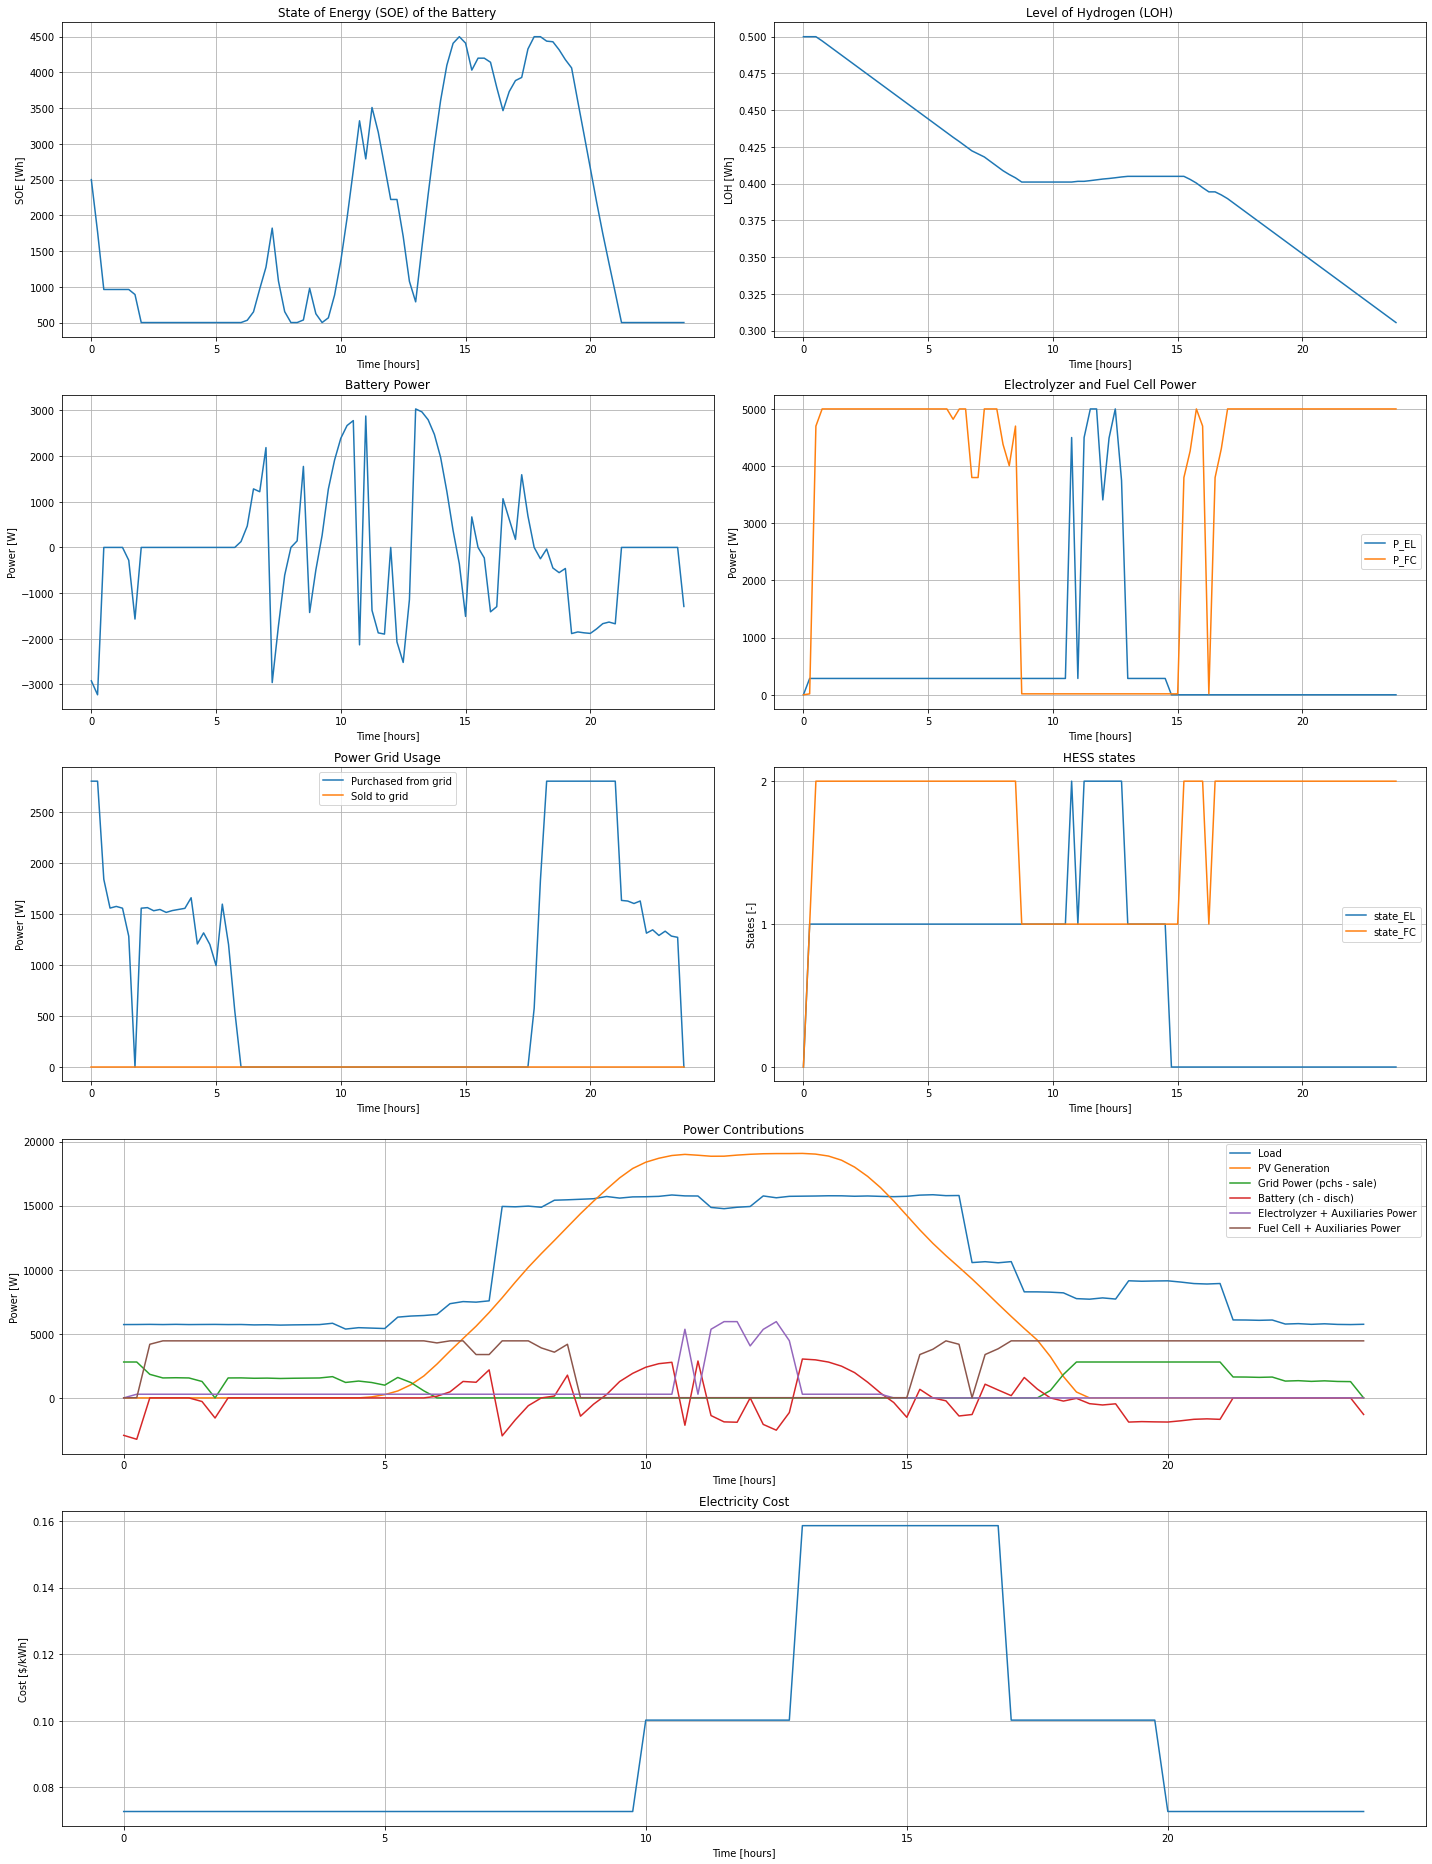

In [82]:

time = np.arange(T/t_s + 1) / 4  # Convert time to hours

plt.figure(figsize=(20, 26))

# Plot SOE
plt.subplot(5, 2, 1)
plt.plot(time[:-1], SOE_opt[:-1])
plt.title('State of Energy (SOE) of the Battery')
plt.xlabel('Time [hours]')
plt.ylabel('SOE [Wh]')
plt.grid(True)

# Plot LOH
plt.subplot(5, 2, 2)
plt.plot(time[:-1], LOH_opt[:-1])
plt.title('Level of Hydrogen (LOH)')
plt.xlabel('Time [hours]')
plt.ylabel('LOH [Wh]')
plt.grid(True)

# Plot P_grid
plt.subplot(5, 2, 5)
plt.plot(time[:-1], P_grid_pchs_opt, label='Purchased from grid')
plt.plot(time[:-1], P_grid_sale_opt, label='Sold to grid')
plt.title('Power Grid Usage')
plt.xlabel('Time [hours]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid(True)

# Plot P_EL and P_FC
plt.subplot(5, 2, 4)
plt.plot(time[:-1], P_EL_opt + P_EL_STB * delta_STB_EL_opt, label='P_EL')
plt.plot(time[:-1], P_FC_opt + P_FC_STB * delta_STB_FC_opt, label='P_FC')
plt.title('Electrolyzer and Fuel Cell Power')
plt.xlabel('Time [hours]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid(True)

# Plot P_batt_opt (Battery Power)
plt.subplot(5, 2, 3)
plt.plot(time[:-1], P_batt_opt)
plt.title('Battery Power')
plt.xlabel('Time [hours]')
plt.ylabel('Power [W]')
plt.grid(True)

# Plot states HESS
plt.subplot(5, 2, 6)
plt.plot(time[:-1], state_EL, label='state_EL')
plt.plot(time[:-1], state_FC, label='state_FC')
plt.title('HESS states')
plt.xlabel('Time [hours]')
plt.ylabel('States [-]')
plt.yticks([0, 1, 2])
plt.legend()
plt.grid(True)

# Plot c_el (Electricity Cost)
plt.subplot(5, 2, (9, 10))
plt.plot(time[:-1], c_el)
plt.title('Electricity Cost')
plt.xlabel('Time [hours]')
plt.ylabel('Cost [$/kWh]')
plt.grid(True)

# Plot all power contributions
plt.subplot(5, 2, (7, 8))
plt.plot(time[:-1], load[:N], label='Load')
plt.plot(time[:-1], pv[:N], label='PV Generation')
plt.plot(time[:-1], P_grid_pchs_opt - P_grid_sale_opt , label='Grid Power (pchs - sale)')
plt.plot(time[:-1], P_batt_opt , label='Battery (ch - disch)')
#plt.plot(time[:-1], P_EL_opt, label='Net Electrolyzer Power')
#plt.plot(time[:-1], P_FC_opt, label='Net Fuel Cell Power')
plt.plot(time[:-1], 1.19*P_EL_opt + P_EL_STB * delta_STB_EL_opt, label='Electrolyzer + Auxiliaries Power')
plt.plot(time[:-1], 0.89*P_FC_opt + P_FC_STB * delta_STB_FC_opt, label='Fuel Cell + Auxiliaries Power')
plt.title('Power Contributions')
plt.xlabel('Time [hours]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid(True)


plt.savefig('MPC_V4_weight=1000_sale=0_Aux.pdf', format='pdf')


plt.tight_layout()
plt.show()



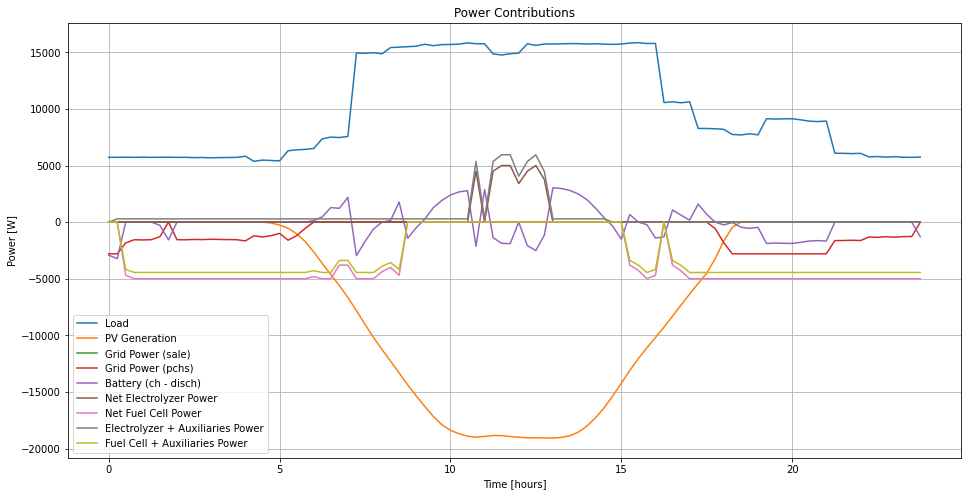

In [70]:
# Plot all power contributions - sgn convention
plt.figure(figsize=(16, 8))

plt.plot(time[:-1], load[:N], label='Load')
plt.plot(time[:-1], - pv[:N], label='PV Generation')
plt.plot(time[:-1], P_grid_sale_opt , label='Grid Power (sale)')
plt.plot(time[:-1], - P_grid_pchs_opt , label='Grid Power (pchs)')
plt.plot(time[:-1], P_batt_opt , label='Battery (ch - disch)')
plt.plot(time[:-1], P_EL_opt, label='Net Electrolyzer Power')
plt.plot(time[:-1], - P_FC_opt, label='Net Fuel Cell Power')
plt.plot(time[:-1], 1.19*P_EL_opt + P_EL_STB * delta_STB_EL_opt, label='Electrolyzer + Auxiliaries Power')
plt.plot(time[:-1], - 0.89*P_FC_opt + P_FC_STB * delta_STB_FC_opt, label='Fuel Cell + Auxiliaries Power')
plt.title('Power Contributions')
plt.xlabel('Time [hours]')
plt.ylabel('Power [W]')

plt.savefig('MPC_V4_Powers_weight=1000_sale=0_Aux.pdf', format='pdf')

plt.legend()
plt.grid(True)


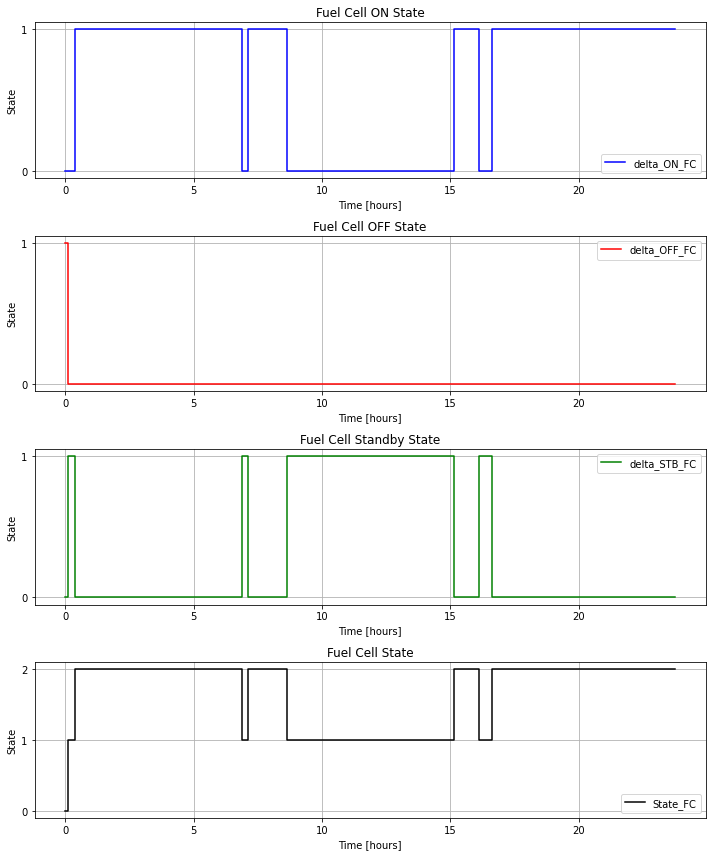

In [124]:
# Plt FC states

plt.figure(figsize=(10, 12))

# Plot delta_ON_FC
plt.subplot(4, 1, 1)
plt.step(time[:-1], delta_ON_FC_opt, label='delta_ON_FC', where='mid', color='blue')
plt.title('Fuel Cell ON State')
plt.xlabel('Time [hours]')
plt.ylabel('State')
plt.yticks([0, 1])  # Set y-axis ticks to only display 0, 1, and 2
plt.legend()
plt.grid(True)

# Plot delta_OFF_FC
plt.subplot(4, 1, 2)
plt.step(time[:-1], delta_OFF_FC_opt, label='delta_OFF_FC', where='mid', color='red')
plt.title('Fuel Cell OFF State')
plt.xlabel('Time [hours]')
plt.ylabel('State')
plt.yticks([0, 1])  # Set y-axis ticks to only display 0, 1, and 2
plt.legend()
plt.grid(True)

# Plot delta_STB_FC
plt.subplot(4, 1, 3)
plt.step(time[:-1], delta_STB_FC_opt, label='delta_STB_FC', where='mid', color='green')
plt.title('Fuel Cell Standby State')
plt.xlabel('Time [hours]')
plt.ylabel('State')
plt.yticks([0, 1])  # Set y-axis ticks to only display 0, 1, and 2
plt.legend()
plt.grid(True)

# Plot State_FC
plt.subplot(4, 1, 4)
plt.step(time[:-1], state_FC, label='State_FC', where='mid', color='black')
plt.title('Fuel Cell State')
plt.xlabel('Time [hours]')
plt.ylabel('State')
plt.yticks([0, 1, 2])  # Set y-axis ticks to only display 0, 1, and 2
plt.legend()
plt.grid(True)


plt.savefig('MPC_V4_stateFC_w=1000.pdf', format='pdf')



plt.tight_layout()
plt.show()



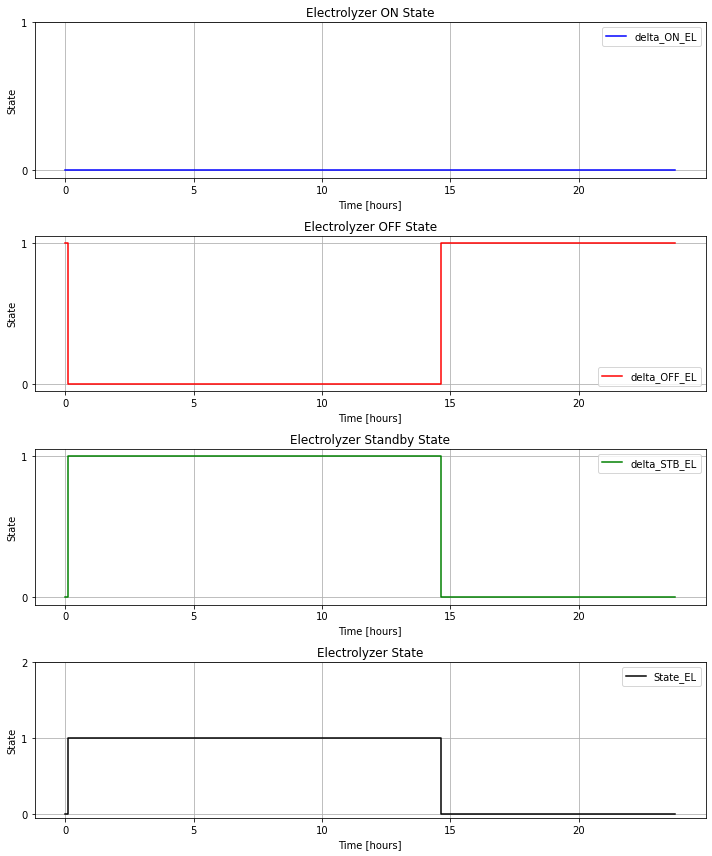

In [125]:
# Plt EL states

plt.figure(figsize=(10, 12))

# Plot delta_ON_EL
plt.subplot(4, 1, 1)
plt.step(time[:-1], delta_ON_EL_opt, label='delta_ON_EL', where='mid', color='blue')
plt.title('Electrolyzer ON State')
plt.xlabel('Time [hours]')
plt.ylabel('State')
plt.yticks([0, 1])  # Set y-axis ticks to only display 0 and 1
plt.legend()
plt.grid(True)

# Plot delta_OFF_EL
plt.subplot(4, 1, 2)
plt.step(time[:-1], delta_OFF_EL_opt, label='delta_OFF_EL', where='mid', color='red')
plt.title('Electrolyzer OFF State')
plt.xlabel('Time [hours]')
plt.ylabel('State')
plt.yticks([0, 1])  # Set y-axis ticks to only display 0 and 1
plt.legend()
plt.grid(True)

# Plot delta_STB_EL
plt.subplot(4, 1, 3)
plt.step(time[:-1], delta_STB_EL_opt, label='delta_STB_EL', where='mid', color='green')
plt.title('Electrolyzer Standby State')
plt.xlabel('Time [hours]')
plt.ylabel('State')
plt.yticks([0, 1])  # Set y-axis ticks to only display 0 and 1
plt.legend()
plt.grid(True)

# Plot State_EL
plt.subplot(4, 1, 4)
plt.step(time[:-1], state_EL, label='State_EL', where='mid', color='black')
plt.title('Electrolyzer State')
plt.xlabel('Time [hours]')
plt.ylabel('State')
plt.yticks([0, 1, 2])  # Set y-axis ticks to only display 0 and 1
plt.legend()
plt.grid(True)


plt.savefig('MPC_V4_stateEL_w=1000.pdf', format='pdf')



plt.tight_layout()
plt.show()



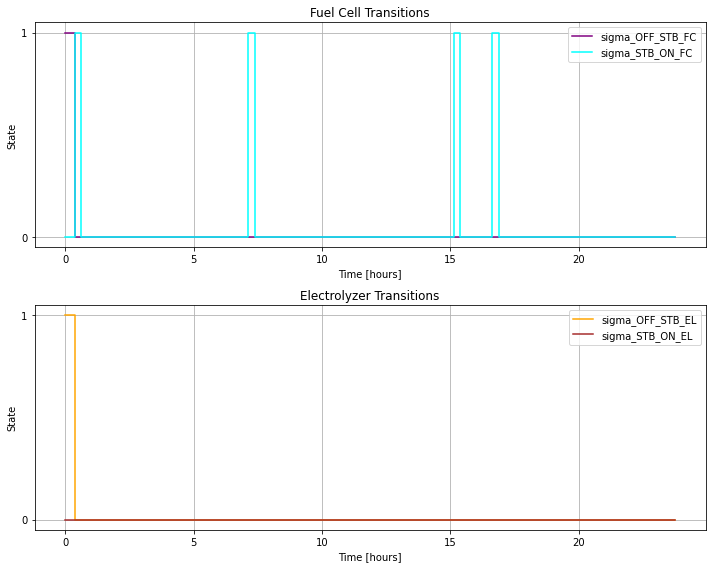

In [126]:
# EL and FC complete transitions

plt.figure(figsize=(10, 8))

# Plot transitions OFF-ON for FC
plt.subplot(2, 1, 1)
plt.step(time[:-1], sigma_OFF_STB_FC_opt, label='sigma_OFF_STB_FC', where='mid', color='purple')
plt.step(time[:-1], sigma_STB_ON_FC_opt, label='sigma_STB_ON_FC', where='mid', color='cyan')
plt.title('Fuel Cell Transitions')
plt.xlabel('Time [hours]')
plt.ylabel('State')
plt.yticks([0, 1])  # Set y-axis ticks to only display 0 and 1
plt.legend()
plt.grid(True)

# Plot transitions OFF-ON for EL
plt.subplot(2, 1, 2)
plt.step(time[:-1], sigma_OFF_STB_EL_opt, label='sigma_OFF_STB_EL', where='mid', color='orange')
plt.step(time[:-1], sigma_STB_ON_EL_opt, label='sigma_STB_ON_EL', where='mid', color='brown')
plt.title('Electrolyzer Transitions')
plt.xlabel('Time [hours]')
plt.ylabel('State')
plt.yticks([0, 1])  # Set y-axis ticks to only display 0 and 1
plt.legend()
plt.grid(True)

plt.savefig('MPC_V4_transitions_w=1000.pdf', format='pdf')


plt.tight_layout()
plt.show()

